# Energy efficiency modeling: residential building

### Objective  
Develop regression models to predict residential building heating and cooling loads based on architectural features.

### Dataset  
[Kaggle - Energy Efficiency Data Set](https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set)

### Input Variables  
- Relative compactness  
- Roof area  
- Overall height  
- Surface area  
- Glazing area  
- Wall area  
- Glazing area distribution of a building  
- Orientation  

### Target Variables  
- Heating load  
- Cooling load


## 1. Data Analysis & Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from math import sqrt
import sys
%matplotlib inline

import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import hyperopt
!pip install catboost
import catboost
from catboost import CatBoostRegressor
from catboost.utils import get_roc_curve
from catboost.utils import eval_metric
import  warnings
warnings.simplefilter('ignore')
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [2]:
pd.set_option("display.max_columns", None)
mpl.rcParams['figure.figsize'] = (12, 10)
#plt.rcParams['axes.labelsize'] = 15
font = {'weight' : 'bold', 'size'   : 15}
plt.rc('font', **font)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
#data = pd.read_csv('energy_efficiency_data.csv')
data = pd.read_csv('/content/drive/My Drive/energy_efficiency_data.csv')
data.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


### 1.1 Understanding the dataset

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [6]:
data.isnull().sum()

,0
Relative_Compactness,0
Surface_Area,0
Wall_Area,0
Roof_Area,0
Overall_Height,0
Orientation,0
Glazing_Area,0
Glazing_Area_Distribution,0
Heating_Load,0
Cooling_Load,0


In [7]:
data.shape

(768, 10)

In [8]:
data.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [9]:
col_num = data.select_dtypes(exclude = ['object']).columns.tolist()
col_num

['Relative_Compactness',
 'Surface_Area',
 'Wall_Area',
 'Roof_Area',
 'Overall_Height',
 'Orientation',
 'Glazing_Area',
 'Glazing_Area_Distribution',
 'Heating_Load',
 'Cooling_Load']

array([[<Axes: title={'center': 'Relative_Compactness'}>,
        <Axes: title={'center': 'Surface_Area'}>,
        <Axes: title={'center': 'Wall_Area'}>],
       [<Axes: title={'center': 'Roof_Area'}>,
        <Axes: title={'center': 'Overall_Height'}>,
        <Axes: title={'center': 'Orientation'}>],
       [<Axes: title={'center': 'Glazing_Area'}>,
        <Axes: title={'center': 'Glazing_Area_Distribution'}>,
        <Axes: title={'center': 'Heating_Load'}>],
       [<Axes: title={'center': 'Cooling_Load'}>, <Axes: >, <Axes: >]],
      dtype=object)

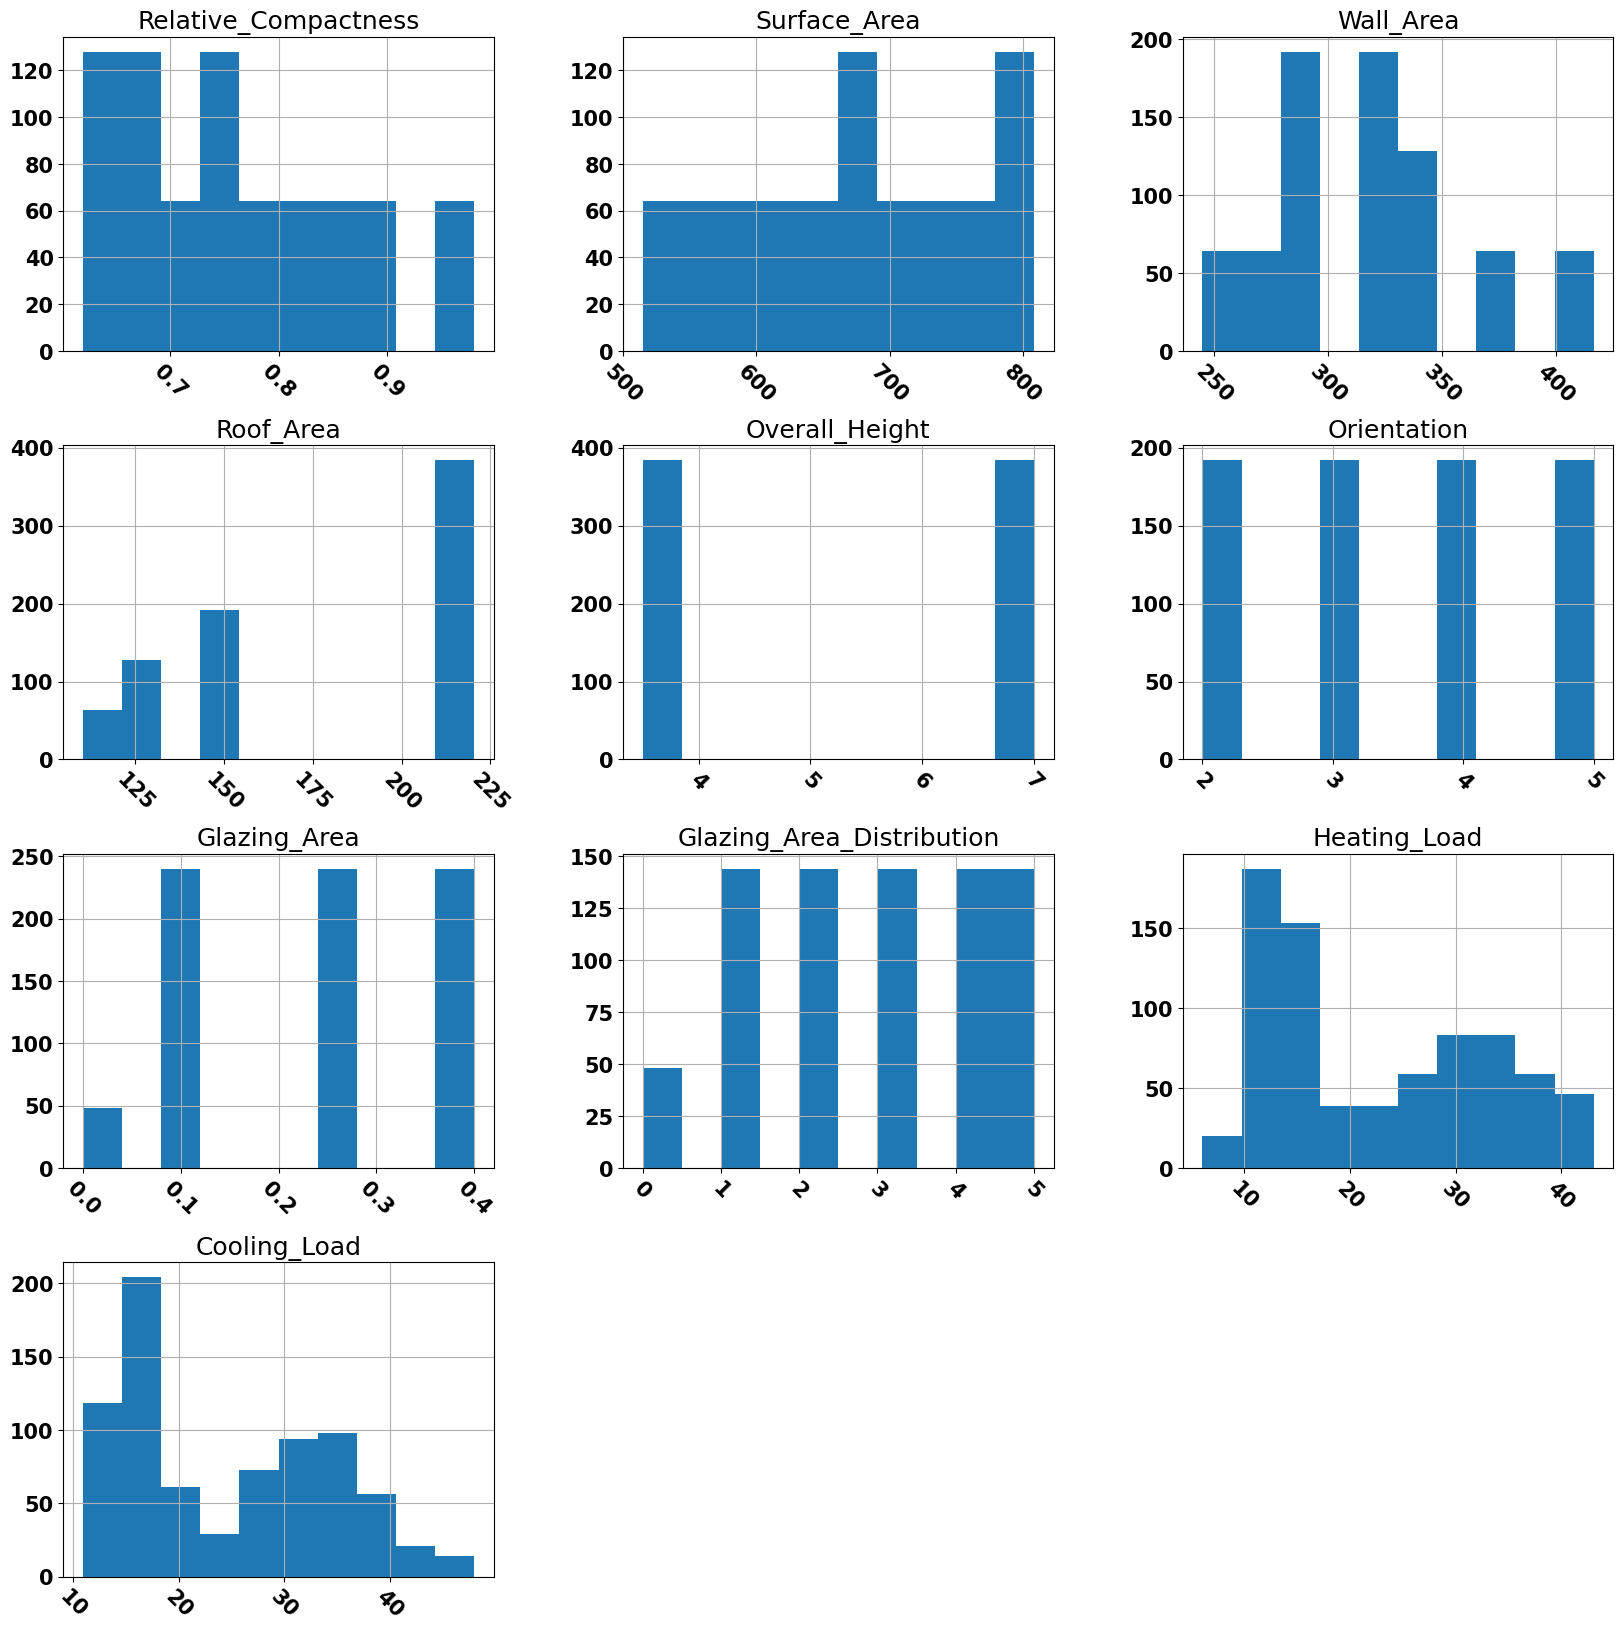

In [10]:
data.hist(figsize=(20,20), xrot=-45)

#### Correlation heatmap for all numerical features

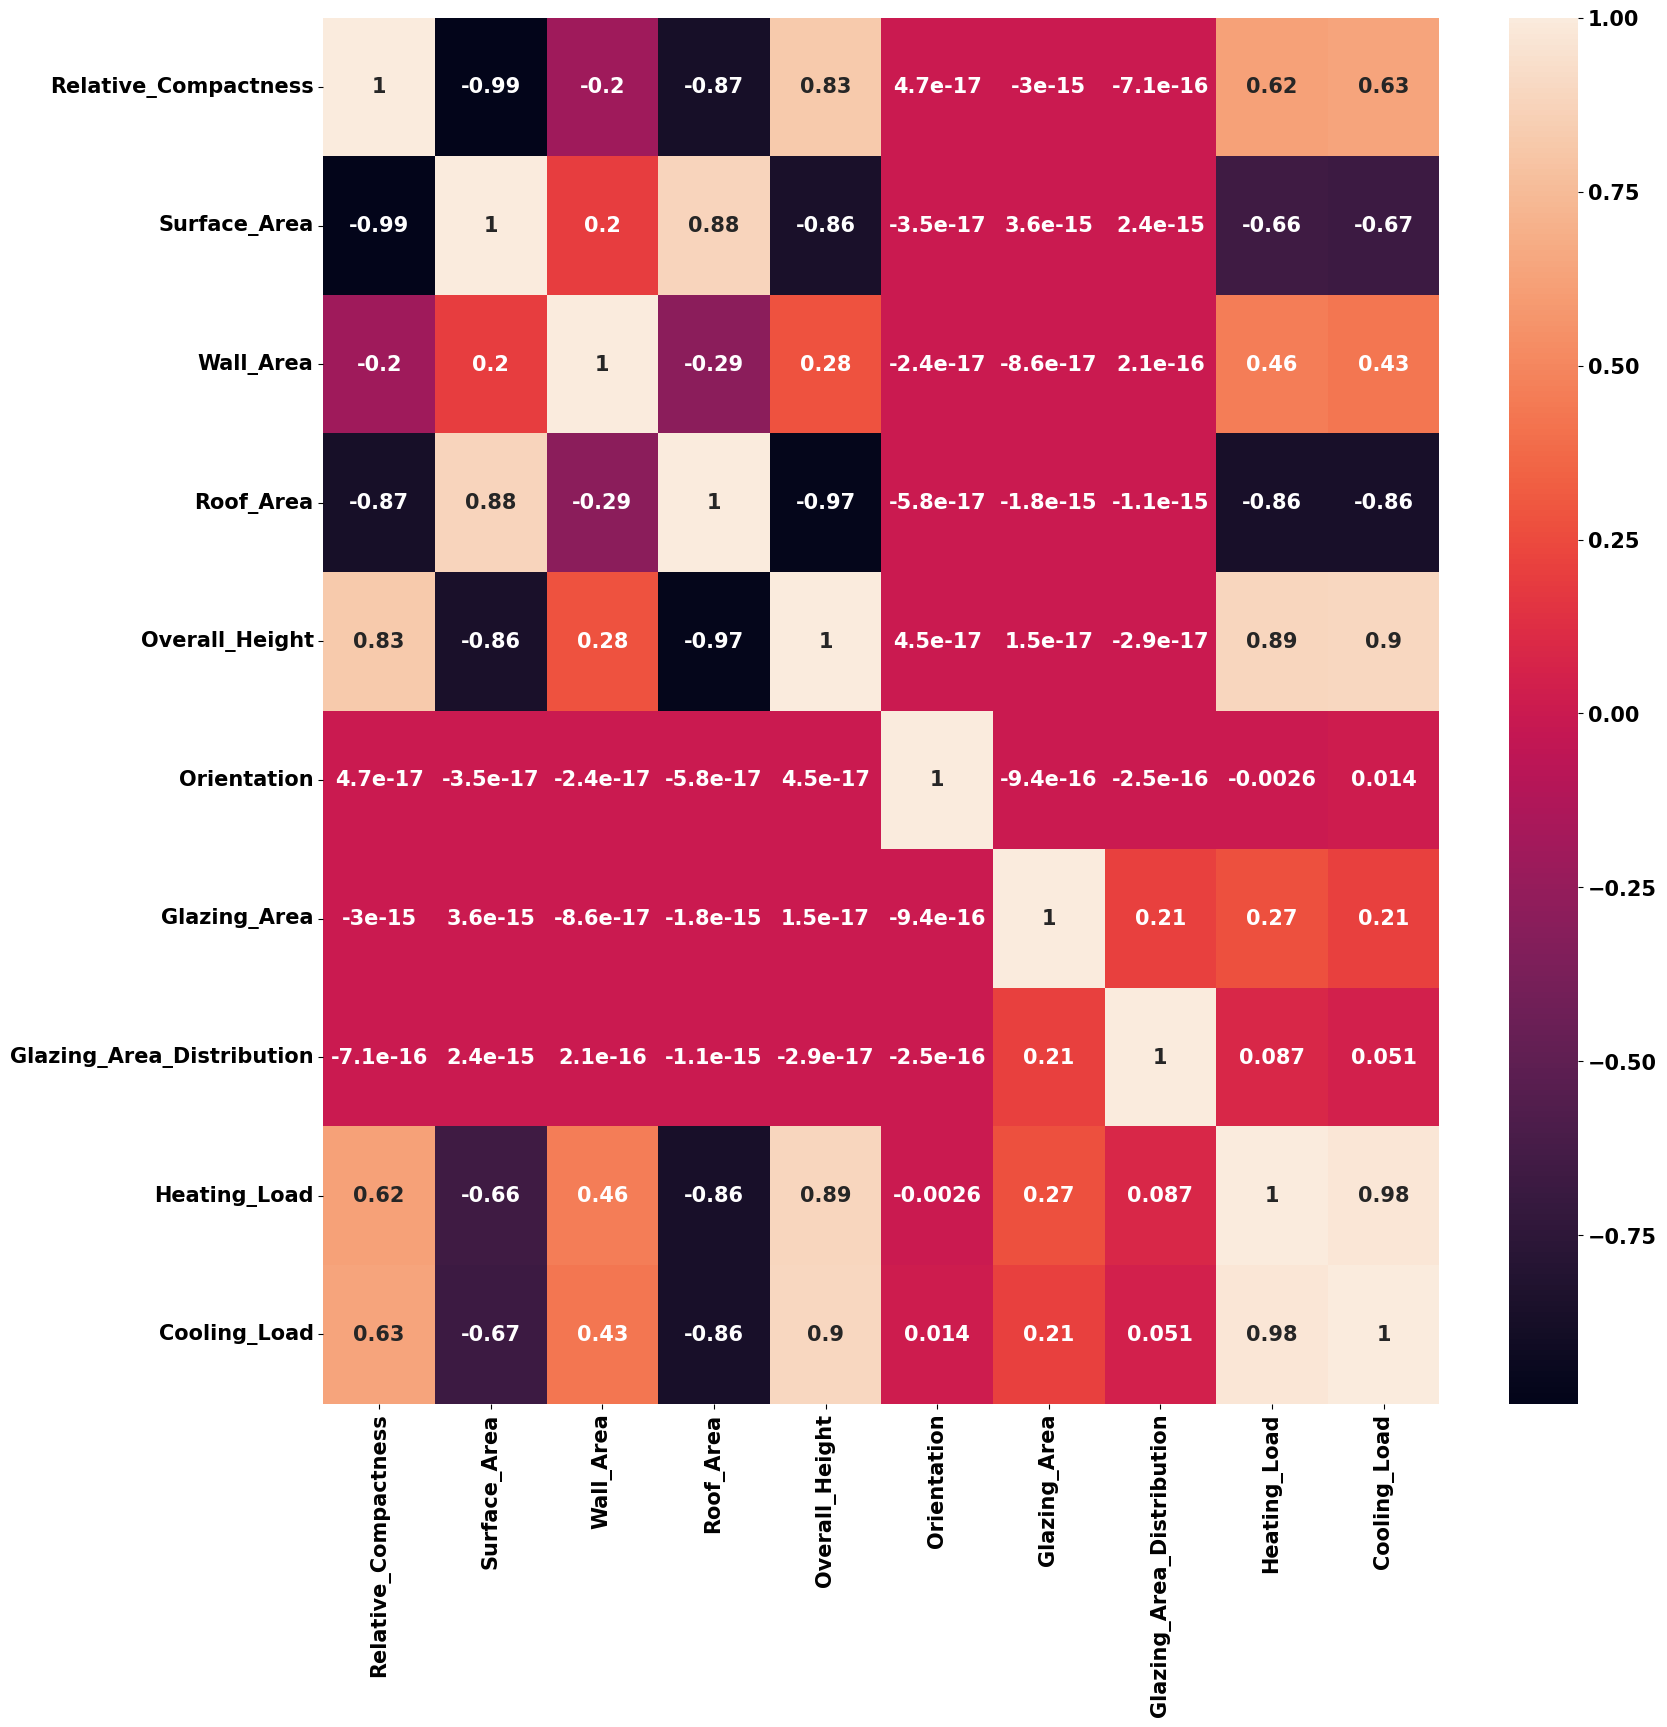

In [11]:
plt.figure(figsize=(18,18))
sns.heatmap(data.select_dtypes(['float64' , 'int64']).corr(),annot=True)
plt.show()

Several variables are highly correlated. For example, relative_compactness, surface_area, and roof_area are all highly correlated. This multicollinearity might affect linear model performance, as linear regression features should be independent.

In [12]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates().dropna()
    return xFlattened

corrFilter(data, .7)

,,0
Relative_Compactness,Surface_Area,-0.991901
Overall_Height,Roof_Area,-0.972512
Relative_Compactness,Roof_Area,-0.868823
Roof_Area,Cooling_Load,-0.862547
Heating_Load,Roof_Area,-0.861828
Overall_Height,Surface_Area,-0.858148
Relative_Compactness,Overall_Height,0.827747
Roof_Area,Surface_Area,0.880720
Heating_Load,Overall_Height,0.889431
Overall_Height,Cooling_Load,0.895785


In [13]:
corr1 = data.corr()[['Cooling_Load']].sort_values(by='Cooling_Load', ascending=False)
corr1

,Cooling_Load
Cooling_Load,1.000000
Heating_Load,0.975862
Overall_Height,0.895785
Relative_Compactness,0.634339
Wall_Area,0.427117
Glazing_Area,0.207505
Glazing_Area_Distribution,0.050525
Orientation,0.014290
Surface_Area,-0.672999
Roof_Area,-0.862547


In [14]:
corr2 = data.corr()[['Heating_Load']].sort_values(by='Heating_Load', ascending=False)
corr2

,Heating_Load
Heating_Load,1.000000
Cooling_Load,0.975862
Overall_Height,0.889431
Relative_Compactness,0.622272
Wall_Area,0.455671
Glazing_Area,0.269841
Glazing_Area_Distribution,0.087368
Orientation,-0.002587
Surface_Area,-0.658120
Roof_Area,-0.861828


For linear models, several variables need to be removed from the feature list: ['Roof_Area','Surface_Area','Relative_Compactness']

In [15]:
#save a copy of data for ensemble modeling
data_ensemble = data

In [16]:
data.to_csv('/content/drive/My Drive/data_processed.csv', index=False) # Now, output to cleaned & engineered data for use

## 3. Modeling
### 3.1. Baseline model-- regularized linear regression

#### Data preparation for linear regression

In [17]:
df = pd.read_csv('/content/drive/My Drive/data_processed.csv')

In [18]:
df.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [19]:
#drop highly correlated features
df = df.drop(columns=['Roof_Area','Surface_Area','Relative_Compactness'], axis =1)

In [20]:
y = df[['Heating_Load', 'Cooling_Load']]
X = df.drop(['Heating_Load','Cooling_Load'], axis=1)
y1 = df[['Heating_Load']]
y2 = df[['Cooling_Load']]

In [21]:
#test_train splitting
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.33, random_state=1234)

#### L1 and L2 regularized linear models

In [69]:
#we use L1 and L2 regularized linear models;
#L1 lasso many coefficients are zeroed out and leads to sparser models;
#feature normalization also happen within the pipeline
pipelines = {
    'Linear_Lasso' : make_pipeline(StandardScaler(),
              Lasso(random_state=123, tol=1e-2, max_iter=10000)),
    'Linear_Ridge' : make_pipeline(StandardScaler(),
              Ridge(random_state=123,  tol=1e-2, max_iter=10000))
}

In [70]:
#lasso：the higher the alpha, the most feature coefficients are zero.
#ridge: the higher the alpha, the impact of coefficient shrinkage grows
lasso_hyperparameters = {
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
ridge_hyperparameters = {
    'ridge__alpha' : [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5, 10]}

hyperparameters = {
    'Linear_Lasso' : lasso_hyperparameters,
    'Linear_Ridge' : ridge_hyperparameters
}

Predicting Heating_Load

In [71]:
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline,
                         hyperparameters[name],
                         cv=10
                         )
    model.fit(X_train, y1_train)
    fitted_models[name] = model

In [72]:
#give R2 as the performance score

for name, model in fitted_models.items():
    print("R^2 for Heating_Load (train data):{}".format(model.best_score_))
    print("Best Hyperparameters:\n{}".format(model.best_params_))

R^2 for Heating_Load (train data):0.9114155659615921
Best Hyperparameters:
{'lasso__alpha': 0.001}
R^2 for Heating_Load (train data):0.9114241423554805
Best Hyperparameters:
{'ridge__alpha': 0.1}


In [73]:
#apply model to test data
#use R2 and MAE as the metrics: mae measures the average of the residuals. mse measures the variance of the residuals
#adding more features always increase the r2, can serve as a signal for high model complexity (overfitting)
metrics1 = []
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    r2 = r2_score(y1_test, pred)
    mae = mean_absolute_error(y1_test, pred)

    # Append the results as a dictionary
    metrics1.append({
        'model': name,
        'heating_load_R2': r2,
        'heating_load_MAE': mae
    })

# Convert the list of dictionaries to a DataFrame
results_df1 = pd.DataFrame(metrics1)
results_df1

,model,heating_load_R2,heating_load_MAE
0,Linear_Lasso,0.918747,2.094254
1,Linear_Ridge,0.918765,2.094231


Predicting Cooling_Load

In [74]:
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline,
                         hyperparameters[name],
                         cv=10
                         )
    model.fit(X_train, y2_train)
    fitted_models[name] = model

In [75]:
#give R2 as the performance score
for name, model in fitted_models.items():
    print("R^2 for Cooling_Load (train data):{}".format(model.best_score_))
    print("Best Hyperparameters:\n{}".format(model.best_params_))

R^2 for Cooling_Load (train data):0.8875275596815433
Best Hyperparameters:
{'lasso__alpha': 0.001}
R^2 for Cooling_Load (train data):0.8875429933640046
Best Hyperparameters:
{'ridge__alpha': 0.1}


In [76]:
#apply model to test data
#use R2 and MAE as the metrics: mae measures the average of the residuals. mse measures the variance of the residuals
#adding more features always increase the r2, can serve as a signal for high model complexity (overfitting)
metrics2 = []
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    r2 = r2_score(y2_test, pred)
    mae = mean_absolute_error(y2_test, pred)

    # Append the results as a dictionary
    metrics2.append({
        'model': name,
        'cooling_load_R2': r2,
        'cooling_load_MAE': mae
    })

# Convert the list of dictionaries to a DataFrame
results_df2 = pd.DataFrame(metrics2)
results_linear_models = pd.merge(results_df1, results_df2, on = 'model')
results_linear_models

,model,heating_load_R2,heating_load_MAE,cooling_load_R2,cooling_load_MAE
0,Linear_Lasso,0.918747,2.094254,0.884375,2.307055
1,Linear_Ridge,0.918765,2.094231,0.884367,2.308016


### 3.2 Ensemble models -- Catboosting, Random Forest, Gradient Boosting

In [37]:
df = pd.read_csv('/content/drive/My Drive/data_processed.csv')
y = df[['Heating_Load', 'Cooling_Load']]
X = df.drop(['Heating_Load','Cooling_Load'], axis=1)
y1 = df[['Heating_Load']]
y2 = df[['Cooling_Load']]

In [38]:
#test_train splitting
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.33, random_state=1234)

In [50]:
regressors = [['Catboostregressor', CatBoostRegressor(verbose=0, random_state=42)],
              ['RandomForestRegressor', RandomForestRegressor(random_state=42)],
              ['GradientBoostingRegressor',GradientBoostingRegressor(random_state=42)]]

In [80]:
# Initialize an empty list to store results
results = []

for name, model in regressors:
    # Fit and evaluate for Heating Load
    model.fit(X_train, y1_train)

    r2_train1 = r2_score(y1_train, model.predict(X_train))
    r2_test1 = r2_score(y1_test, model.predict(X_test))

    # Fit and evaluate for Cooling Load
    model.fit(X_train, y2_train)

    r2_train2 = r2_score(y2_train, model.predict(X_train))
    r2_test2 = r2_score(y2_test, model.predict(X_test))

    # Append the results as a dictionary
    results.append({
        'model': name,
        'train_Heating': r2_train1,
        'test_Heating': r2_test1,
        'train_Cooling': r2_train2,
        'test_Cooling': r2_test2
    })

# Convert the list of dictionaries to a DataFrame
r2 = pd.DataFrame(results)

# Sort the DataFrame by 'test_Cooling'
r2_sorted = r2.sort_values(by='test_Cooling')

print(r2_sorted)

                       model  train_Heating  test_Heating  train_Cooling  \
1      RandomForestRegressor       0.999654      0.997605       0.995202   
2  GradientBoostingRegressor       0.998310      0.997560       0.979275   
0          Catboostregressor       0.999830      0.998730       0.999011   

   test_Cooling  
1      0.966902  
2      0.976941  
0      0.995575  


#### 3.2.1 Hyperparameter Tuning -Catboosting

In [49]:
model_CBR = CatBoostRegressor(verbose=0, random_state=42)
parameters = { 'depth': [6, 8, 10],
    'iterations': [1000],
    'learning_rate': [0.01, 0.03],
    'l2_leaf_reg': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bylevel': [0.8, 1.0],
    'random_strength': [1, 5],
    'min_data_in_leaf': [1, 10]
}

grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y2_train)

print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)


 The best score across ALL searched params:
 0.9830505669298844

 The best parameters across ALL searched params:
 {'colsample_bylevel': 0.8, 'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'min_data_in_leaf': 1, 'random_strength': 1, 'subsample': 1.0}


3.2.2 Hyperparameter Tuning - Random Forest

In [53]:
model_RF = RandomForestRegressor(random_state=42)
parameters = { 'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    #'max_features': ['auto', 'sqrt']
}


grid = GridSearchCV(estimator=model_RF, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y2_train)

print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)


 The best score across ALL searched params:
 0.9610731307530356

 The best parameters across ALL searched params:
 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


3.2.1 Hyperparameter Tuning - Gradient Boosting

In [55]:
model_GB = GradientBoostingRegressor(random_state=42)
parameters = {  'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2'],
    'loss': ['squared_error', 'huber']
}


grid = GridSearchCV(estimator=model_GB, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y2_train)

print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)


 The best score across ALL searched params:
 0.9768713634063386

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 1.0}


3.2.4 Comparing tuned *models*

In [57]:
regressors_tuned = [['Catboostregressor', CatBoostRegressor(verbose=0, random_state=42, colsample_bylevel= 0.8, depth= 6, iterations= 1000, l2_leaf_reg= 3, learning_rate= 0.03, min_data_in_leaf= 1, random_strength= 1, subsample= 1.0)],
              ['RandomForestRegressor', RandomForestRegressor(random_state=42,max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300 )],
              ['GradientBoostingRegressor',GradientBoostingRegressor(random_state=42, learning_rate= 0.1, loss='squared_error', max_depth= 5, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 5, n_estimators= 200, subsample= 1.0)]]

In [84]:
# Initialize an empty list to store results
metrics_results = []

for name, model in regressors_tuned:
    # Fit and evaluate for Heating Load
    model.fit(X_train, y1_train)
    y1_pred = model.predict(X_test)
    r2_heating = r2_score(y1_test, y1_pred)
    mae_heating = mean_absolute_error(y1_test, y1_pred)

    # Fit and evaluate for Cooling Load
    model.fit(X_train, y2_train)
    y2_pred = model.predict(X_test)
    r2_cooling = r2_score(y2_test, y2_pred)
    mae_cooling = mean_absolute_error(y2_test, y2_pred)

    # Append the results as a dictionary
    metrics_results.append({
        'model': name,
        'heating_load_R2': r2_heating,
        'heating_load_MAE': mae_heating,
        'cooling_load_R2': r2_cooling,
        'cooling_load_MAE': mae_cooling
    })

# Convert the list of dictionaries to a DataFrame
results_df3 = pd.DataFrame(metrics_results)
metrics_compared = pd.concat([results_linear_models, results_df3], ignore_index=True)

metrics_compared

,model,heating_load_R2,heating_load_MAE,cooling_load_R2,cooling_load_MAE
0,Linear_Lasso,0.918747,2.094254,0.884375,2.307055
1,Linear_Ridge,0.918765,2.094231,0.884367,2.308016
2,Catboostregressor,0.998744,0.237380,0.994934,0.476520
3,RandomForestRegressor,0.997610,0.324974,0.967617,1.071800
4,GradientBoostingRegressor,0.998238,0.270094,0.991080,0.617589


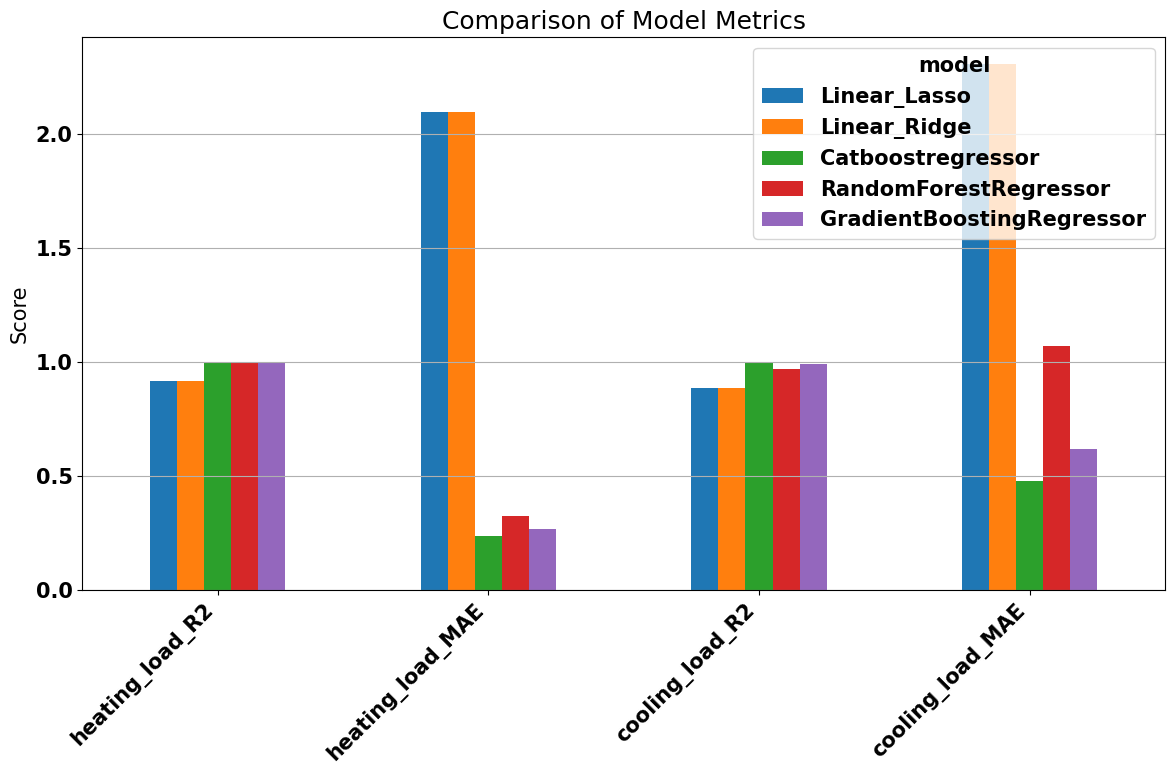

In [85]:
# prompt: plot out the metrics_compared

# Transpose the DataFrame to make models the index and metrics columns
metrics_compared_T = metrics_compared.set_index('model').T

# Create a bar plot
metrics_compared_T.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Model Metrics')
plt.ylabel('Metrics')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Catboosting regressor is the best model, with the lowest MAE and highest R2 score for both heating load and cooling load.

#### 3.3 Understanding the model

In [87]:
cb_heating = CatBoostRegressor(verbose=0, random_state=42, colsample_bylevel= 0.8, depth= 6, iterations= 1000, l2_leaf_reg= 3, learning_rate= 0.03, min_data_in_leaf= 1, random_strength= 1, subsample= 1.0)
cb_heating.fit(X_train, y1_train)

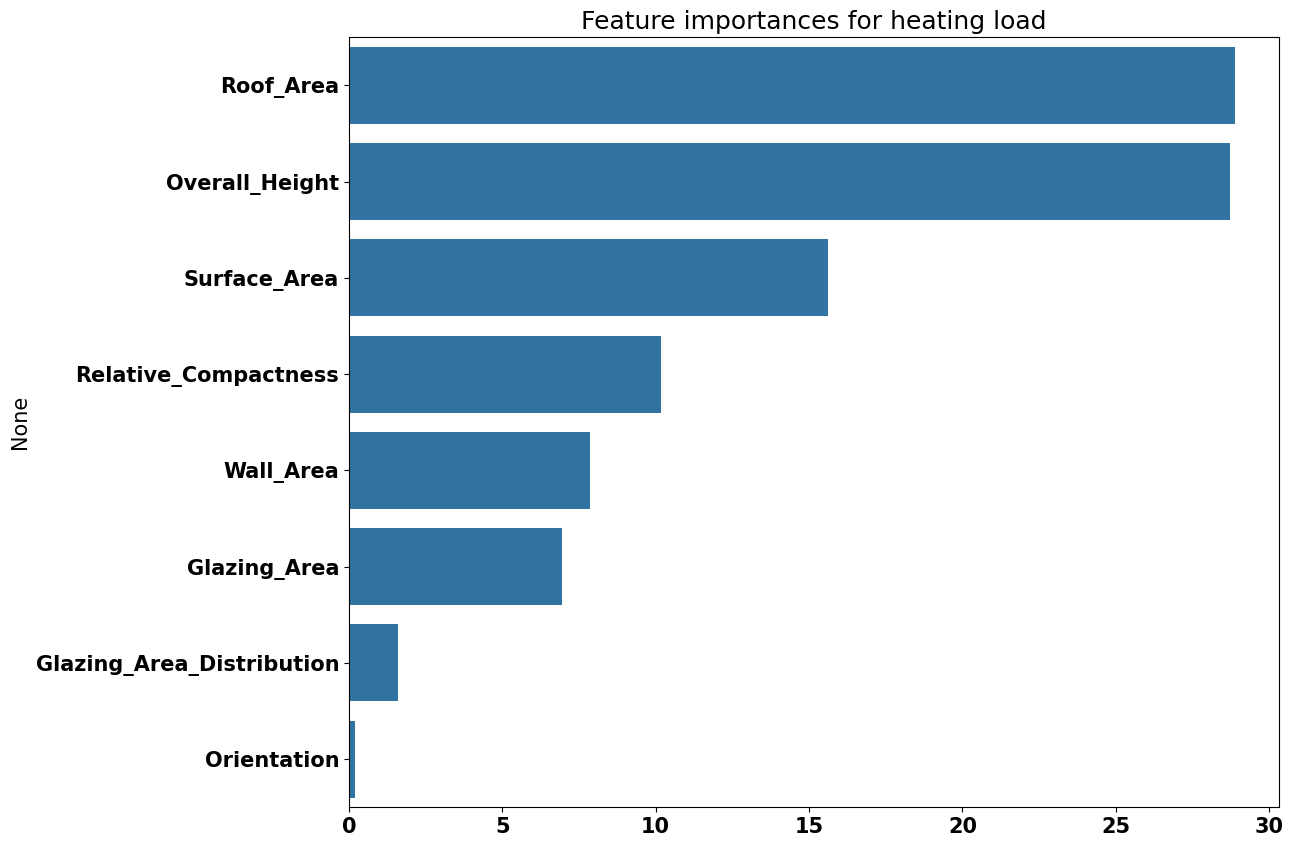

In [90]:
importances = cb_heating.feature_importances_
cb_heating_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

ax = sns.barplot(y=cb_heating_importances.index, x = cb_heating_importances.values).set(title='Feature importances for heating load')
plt.show()

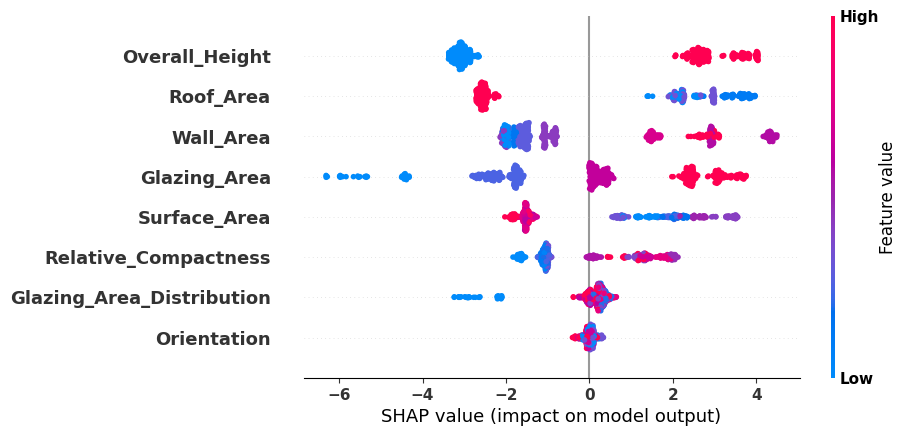

In [92]:
#get shap values
explainer = shap.Explainer(cb_heating)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)


In [93]:
cb_cooling = CatBoostRegressor(verbose=0, random_state=42, colsample_bylevel= 0.8, depth= 6, iterations= 1000, l2_leaf_reg= 3, learning_rate= 0.03, min_data_in_leaf= 1, random_strength= 1, subsample= 1.0)
cb_cooling.fit(X_train, y2_train)

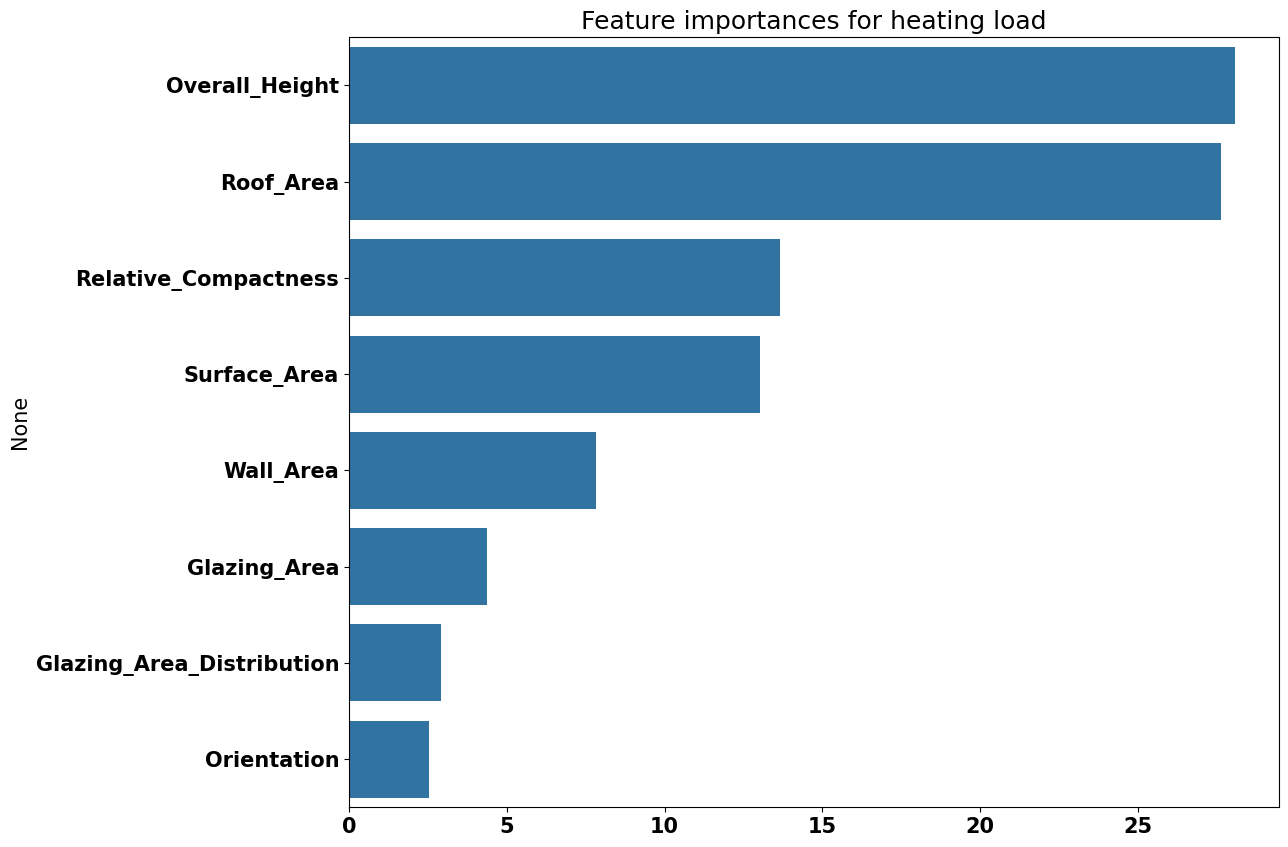

In [94]:
importances = cb_cooling.feature_importances_
cb_cooling_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

ax = sns.barplot(y=cb_cooling_importances.index, x = cb_cooling_importances.values).set(title='Feature importances for heating load')
plt.show()

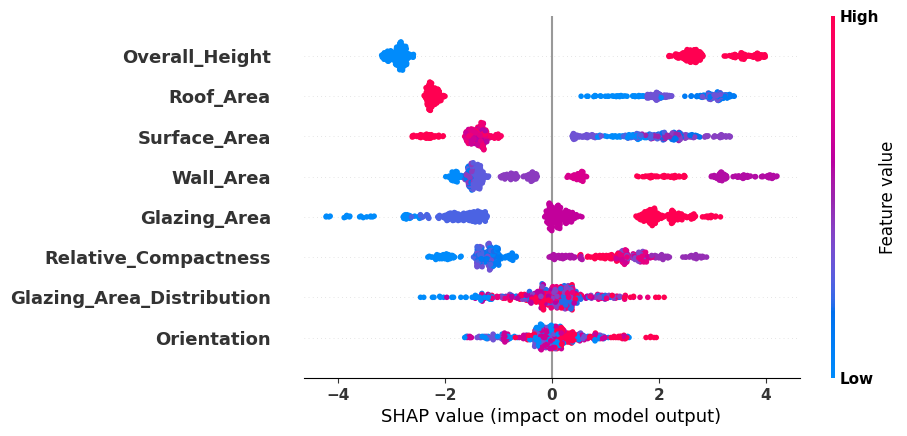

In [95]:
#get shap values
explainer = shap.Explainer(cb_cooling)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

## 4.Results